<a href="https://colab.research.google.com/github/cristonpinto/Face-recognition-Attendance-System/blob/main/BSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install scikit-image


In [2]:
# Download BSD500 Dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz

# Extract the dataset
!tar -xzvf BSR_full.tgz

# Verify extraction
!ls BSR

--2025-03-25 17:38:47--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170185251 (162M) [application/x-tar]
Saving to: ‘BSR_full.tgz’

BSR_full.tgz        100%[===================>] 162.30M  41.3MB/s    in 4.4s    

2025-03-25 17:38:52 (36.5 MB/s) - ‘BSR_full.tgz’ saved [170185251/170185251]

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import os
from google.colab import files
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
import io

# Define loss
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Load BSDS500 images
train_dir = "/content/BSR/BSDS500/data/images/train/"
val_dir = "/content/BSR/BSDS500/data/images/val/"
test_dir = "/content/BSR/BSDS500/data/images/test/"

train_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.jpg')]
val_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith('.jpg')]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

image_files = train_files + val_files
print(f"Using {len(image_files)} training images (train + val), {len(test_files)} test images")

def load_images(file_list, size=(64, 64)):
    images = []
    for file in file_list:
        img = cv2.imread(file)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) / 255.0
        images.append(img)
    return np.array(images)

def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

x_train = load_images(image_files)
x_test = load_images(test_files[:50])
x_test_noisy = add_noise(x_test, sigma=0.05)

# Create noisy versions with different sigma values
sigmas = [0.05, 0.1, 0.2]
x_train_noisy_mixed = []
x_train_mixed = []
for i, img in enumerate(x_train):
    sigma = sigmas[i % len(sigmas)]
    noisy_img = add_noise(np.expand_dims(img, 0), sigma=sigma)[0]
    x_train_noisy_mixed.append(noisy_img)
    x_train_mixed.append(img)
x_train_noisy_mixed = np.array(x_train_noisy_mixed)
x_train_mixed = np.array(x_train_mixed)

# Upload your screenshot
uploaded = files.upload()
filename = list(uploaded.keys())[0]
real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img, (64, 64)) / 255.0

# Add screenshot with mixed noise
for sigma in sigmas:
    real_img_train = np.expand_dims(real_img, 0)
    real_img_noisy_train = add_noise(real_img_train, sigma=sigma)
    x_train_mixed = np.concatenate([x_train_mixed, real_img_train])
    x_train_noisy_mixed = np.concatenate([x_train_noisy_mixed, real_img_noisy_train])
print(f"Total training images: {len(x_train_mixed)}")

# Define U-Net
def unet_autoencoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Dropout(0.1)(b)
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Dropout(0.1)(c3)
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Dropout(0.1)(c4)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)
    return Model(inputs, outputs)

model = unet_autoencoder()
model.compile(optimizer='adam', loss=combined_loss)

# Train
model.fit(x_train_noisy_mixed, x_train_mixed, epochs=50, batch_size=16,
          validation_data=(x_test_noisy, x_test),
          callbacks=[ModelCheckpoint('/content/drive/MyDrive/CW2_Image_Denoising/models/model_bsds500_mixed.h5', save_best_only=True)])

# Download the trained model
print("Downloading the trained model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_bsds500_mixed.h5')

Using 300 training images (train + val), 200 test images


Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609.png
Total training images: 303
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.2605

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - loss: 0.2587 - val_loss: 0.1700
Epoch 2/50
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1614

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1579 - val_loss: 0.0873
Epoch 3/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1184

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1172 - val_loss: 0.0620
Epoch 4/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1032

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1020 - val_loss: 0.0495
Epoch 5/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0915

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0912 - val_loss: 0.0449
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0856 - val_loss: 0.0466
Epoch 7/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0849

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0844 - val_loss: 0.0445
Epoch 8/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0813

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0808 - val_loss: 0.0399
Epoch 9/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0741

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0748 - val_loss: 0.0367
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0802 - val_loss: 0.0384
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0779 - val_loss: 0.0373
Epoch 12/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0723

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0723 - val_loss: 0.0359
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0727 - val_loss: 0.0407
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0744 - val_loss: 0.0367
Epoch 15/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0711

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0708 - val_loss: 0.0326
Epoch 16/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0669 - val_loss: 0.0326
Epoch 17/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0676

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0677 - val_loss: 0.0320
Epoch 18/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0701 - val_loss: 0.0396
Epoch 19/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0677

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0679 - val_loss: 0.0318
Epoch 20/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0667 - val_loss: 0.0378
Epoch 21/50
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0677

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0680 - val_loss: 0.0313
Epoch 22/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0680

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0677 - val_loss: 0.0312
Epoch 23/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0626

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0630 - val_loss: 0.0306
Epoch 24/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0674 - val_loss: 0.0315
Epoch 25/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0644 - val_loss: 0.0307
Epoch 26/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0638 - val_loss: 0.0312
Epoch 27/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0648

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0644 - val_loss: 0.0290
Epoch 28/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0641

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0637 - val_loss: 0.0287
Epoch 29/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0607 - val_loss: 0.0310
Epoch 30/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0617 - val_loss: 0.0293
Epoch 31/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0640 - val_loss: 0.0289
Epoch 32/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0631 - val_loss: 0.0305
Epoch 33/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0630

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0626 - val_loss: 0.0285
Epoch 34/50
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0629

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0626 - val_loss: 0.0284
Epoch 35/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0620 - val_loss: 0.0314
Epoch 36/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0622 - val_loss: 0.0291
Epoch 37/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0605 - val_loss: 0.0292
Epoch 38/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0619 - val_loss: 0.0286
Epoch 39/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0591 - val_loss: 0.0301
Epoch 40/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0575 - val_loss: 0.0297
Epoch 41/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0585 - val_loss: 0.0287
Epoch 42/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0597

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0597 - val_loss: 0.0282
Epoch 43/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0601 - val_loss: 0.0282
Epoch 44/50
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0556

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0562 - val_loss: 0.0276
Epoch 45/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0612 - val_loss: 0.0298
Epoch 46/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0591 - val_loss: 0.0282
Epoch 47/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0578 - val_loss: 0.0279
Epoch 48/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0562 - val_loss: 0.0282
Epoch 49/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0614 - val_loss: 0.0281
Epoch 50/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0585 - val_loss: 0.0301


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving download (5).jpeg to download (5).jpeg
Saving download.webp to download.webp

Processing download (5).jpeg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Sigma=0.05:
  Denoised PSNR: 23.14 dB, SSIM: 0.83
  Sharpened PSNR: 18.56 dB, SSIM: 0.69


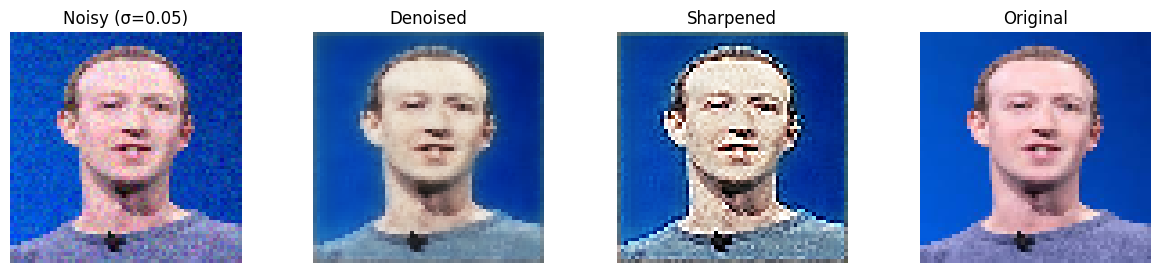

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sigma=0.1:
  Denoised PSNR: 21.83 dB, SSIM: 0.79
  Sharpened PSNR: 17.92 dB, SSIM: 0.65


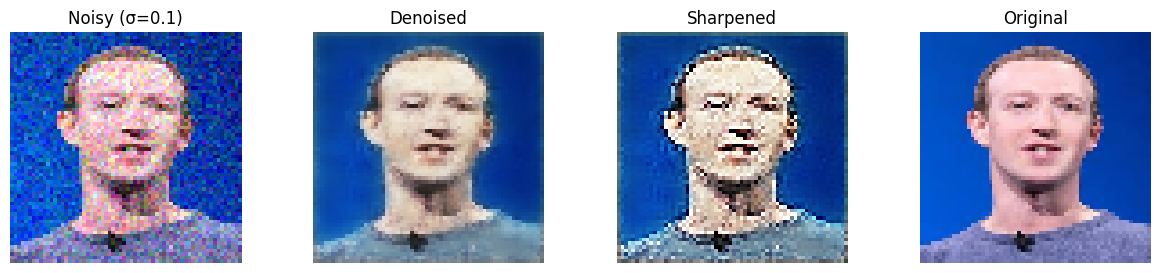

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sigma=0.2:
  Denoised PSNR: 19.79 dB, SSIM: 0.70
  Sharpened PSNR: 16.59 dB, SSIM: 0.56


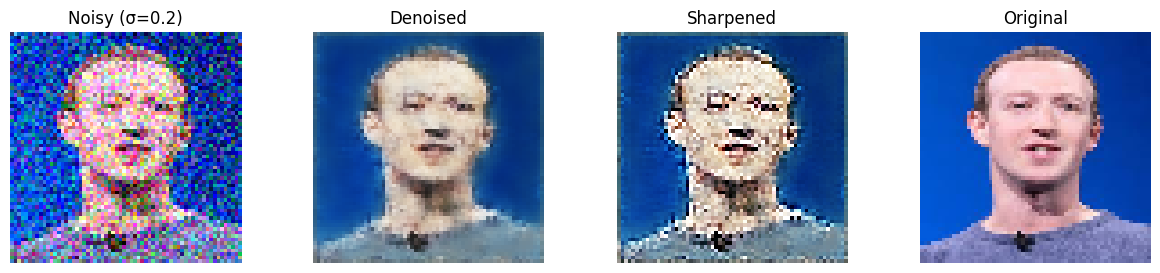

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Processing download.webp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sigma=0.05:
  Denoised PSNR: 29.62 dB, SSIM: 0.92
  Sharpened PSNR: 20.84 dB, SSIM: 0.77


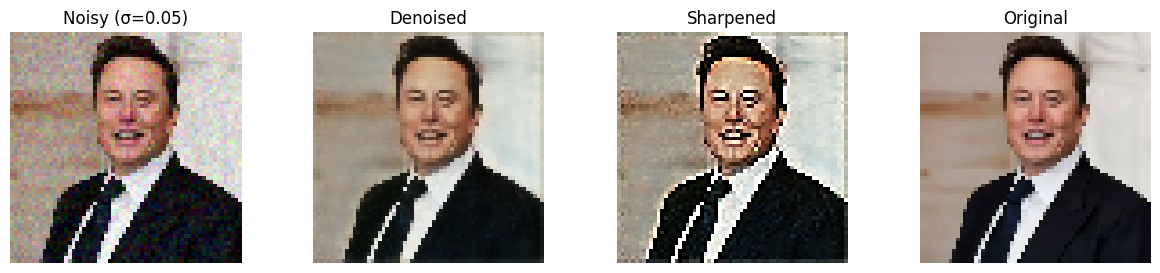

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sigma=0.1:
  Denoised PSNR: 27.37 dB, SSIM: 0.87
  Sharpened PSNR: 20.08 dB, SSIM: 0.70


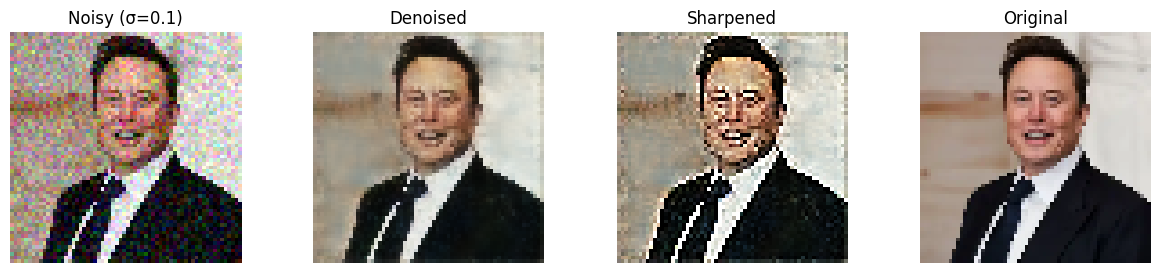

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sigma=0.2:
  Denoised PSNR: 23.98 dB, SSIM: 0.75
  Sharpened PSNR: 18.96 dB, SSIM: 0.59


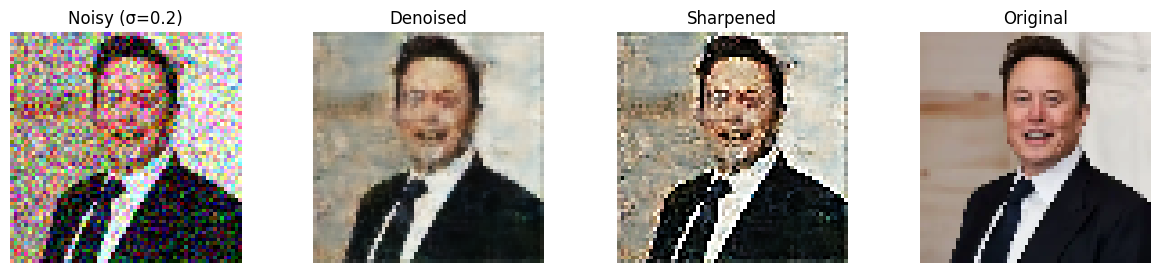

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define loss (for loading the model)
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Load the trained model
model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_bsds500_mixed.h5',
                   custom_objects={'combined_loss': combined_loss})

# Noise function
def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

# Upload multiple images
print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    # Test with different sigma values
    for sigma in [0.05, 0.1, 0.2]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = model.predict(real_img_noisy)[0]

        # Milder sharpening
        sharpen_kernel = np.array([[0, -0.5, 0], [-0.5, 3, -0.5], [0, -0.5, 0]])
        real_denoised_sharp = cv2.filter2D(real_denoised, -1, sharpen_kernel)
        real_denoised_sharp = np.clip(real_denoised_sharp, 0, 1)

        # Metrics
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        psnr_sharp = peak_signal_noise_ratio(real_img, real_denoised_sharp, data_range=1.0)
        ssim_sharp = structural_similarity(real_img, real_denoised_sharp, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")
        print(f"  Sharpened PSNR: {psnr_sharp:.2f} dB, SSIM: {ssim_sharp:.2f}")

        # Visualize
        plt.figure(figsize=(15, 3))
        plt.subplot(1, 4, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(real_denoised_sharp); plt.title("Sharpened"); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_bsds500.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609 (1).png

Processing Screenshot 2025-02-26 223609 (1).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Sigma=0.05:
  Denoised PSNR: 26.57 dB, SSIM: 0.90
  Sharpened PSNR: 19.49 dB, SSIM: 0.78


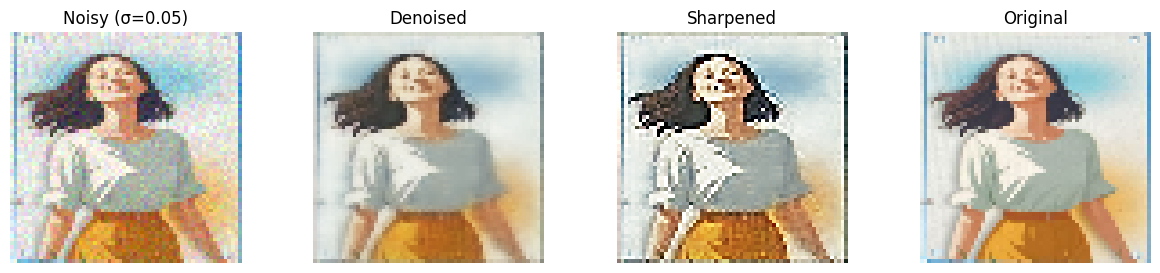

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sigma=0.1:
  Denoised PSNR: 25.23 dB, SSIM: 0.86
  Sharpened PSNR: 18.94 dB, SSIM: 0.71


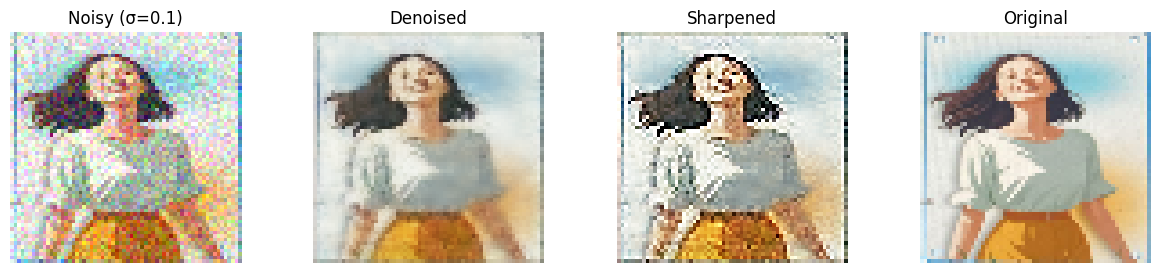

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sigma=0.2:
  Denoised PSNR: 21.97 dB, SSIM: 0.73
  Sharpened PSNR: 18.10 dB, SSIM: 0.62


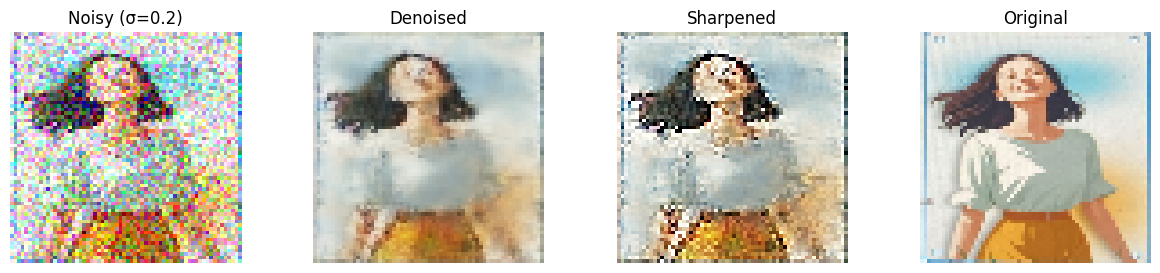

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define loss (for loading the model)
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Load the trained model
model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_bsds500_mixed.h5',
                   custom_objects={'combined_loss': combined_loss})

# Noise function
def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

# Upload multiple images
print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    # Test with different sigma values
    for sigma in [0.05, 0.1, 0.2]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = model.predict(real_img_noisy)[0]

        # Milder sharpening
        sharpen_kernel = np.array([[0, -0.5, 0], [-0.5, 3, -0.5], [0, -0.5, 0]])
        real_denoised_sharp = cv2.filter2D(real_denoised, -1, sharpen_kernel)
        real_denoised_sharp = np.clip(real_denoised_sharp, 0, 1)

        # Metrics
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        psnr_sharp = peak_signal_noise_ratio(real_img, real_denoised_sharp, data_range=1.0)
        ssim_sharp = structural_similarity(real_img, real_denoised_sharp, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")
        print(f"  Sharpened PSNR: {psnr_sharp:.2f} dB, SSIM: {ssim_sharp:.2f}")

        # Visualize
        plt.figure(figsize=(15, 3))
        plt.subplot(1, 4, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(real_denoised_sharp); plt.title("Sharpened"); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_bsds500.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

Upload your model file (model_bsds500_mixed.h5):


Saving model_bsds500_mixed.h5 to model_bsds500_mixed.h5
--2025-03-25 17:49:50--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-03-25 17:49:50--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘/content/DIV2K_train_HR.zip’

/content/DIV2K_trai 100%[===================>]   3.29G  30.3MB/s    in 1m 51s  

2025-03-25 17:51:41 (30.5 MB/s) - ‘/content/DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Loaded 800 DIV2K images
Upload your screen

Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609 (2).png
Total training images: 803
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0638

46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: 0.0637 - val_loss: 0.0524
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0562 - val_loss: 0.0544
Epoch 3/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0565

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0564 - val_loss: 0.0492
Epoch 4/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0567

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0565 - val_loss: 0.0485
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0552 - val_loss: 0.0489
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0557 - val_loss: 0.0519
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0565 - val_loss: 0.0497
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0560 - val_loss: 0.0498
Epoch 9/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0548

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0547 - val_loss: 0.0481
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0525 - val_loss: 0.0500
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0543 - val_loss: 0.0485
Epoch 12/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0546

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0544 - val_loss: 0.0474
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0516 - val_loss: 0.0483
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0530 - val_loss: 0.0474
Epoch 15/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0525

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0524 - val_loss: 0.0464
Epoch 16/20
41/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0506

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0507 - val_loss: 0.0463
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0532 - val_loss: 0.0479
Epoch 18/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0501 - val_loss: 0.0474
Epoch 19/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0506 - val_loss: 0.0468
Epoch 20/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0506 - val_loss: 0.0481


Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving download (5).jpeg to download (5) (1).jpeg
Saving download.webp to download (1).webp
Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609 (3).png

Processing download (5) (1).jpeg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Sigma=0.05:
  Denoised PSNR: 23.76 dB, SSIM: 0.88
  Sharpened PSNR: 18.89 dB, SSIM: 0.73


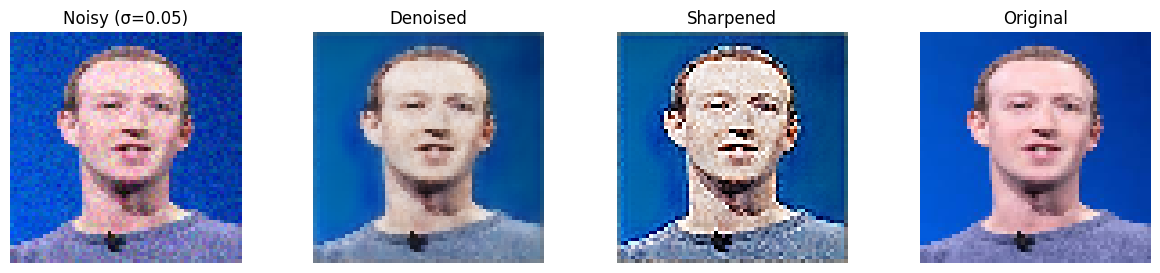

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sigma=0.1:
  Denoised PSNR: 22.46 dB, SSIM: 0.83
  Sharpened PSNR: 17.88 dB, SSIM: 0.67


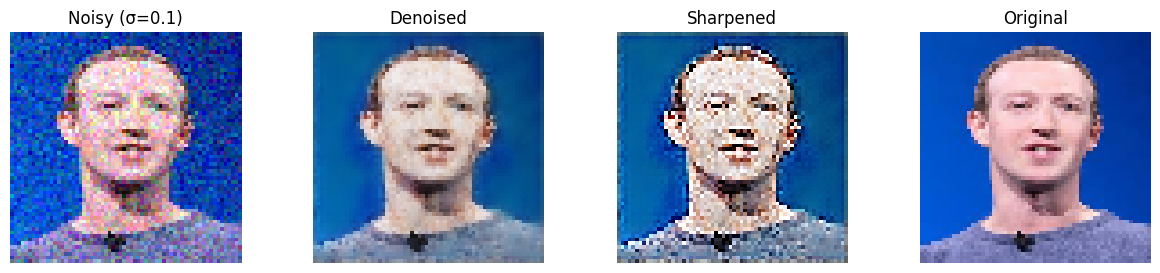

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sigma=0.2:
  Denoised PSNR: 20.43 dB, SSIM: 0.74
  Sharpened PSNR: 16.46 dB, SSIM: 0.58


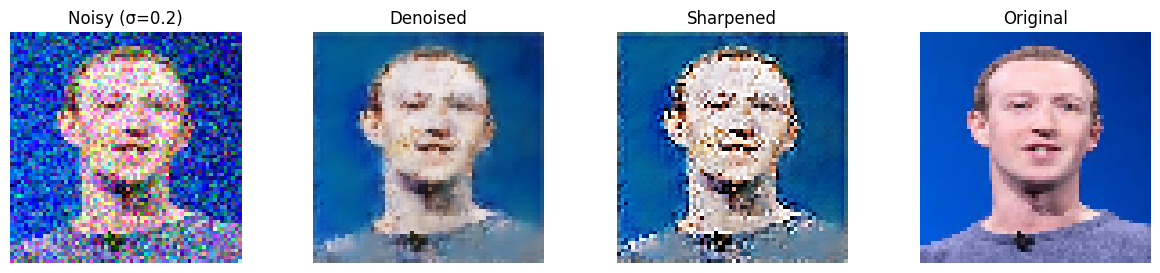

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Processing download (1).webp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sigma=0.05:
  Denoised PSNR: 30.17 dB, SSIM: 0.93
  Sharpened PSNR: 20.83 dB, SSIM: 0.79


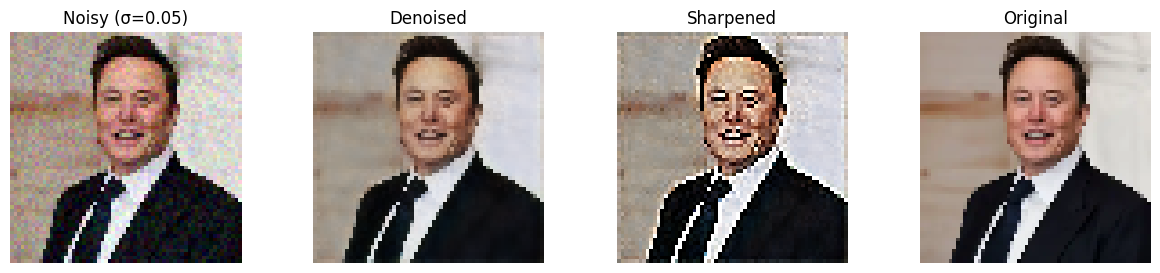

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.1:
  Denoised PSNR: 27.66 dB, SSIM: 0.87
  Sharpened PSNR: 19.98 dB, SSIM: 0.72


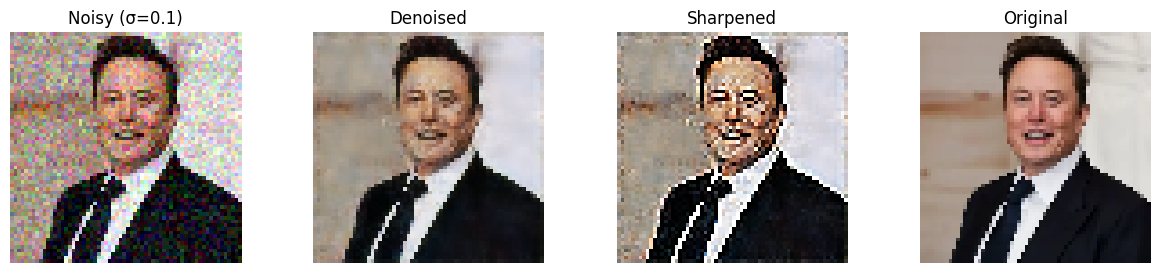

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.2:
  Denoised PSNR: 24.16 dB, SSIM: 0.79
  Sharpened PSNR: 18.01 dB, SSIM: 0.62


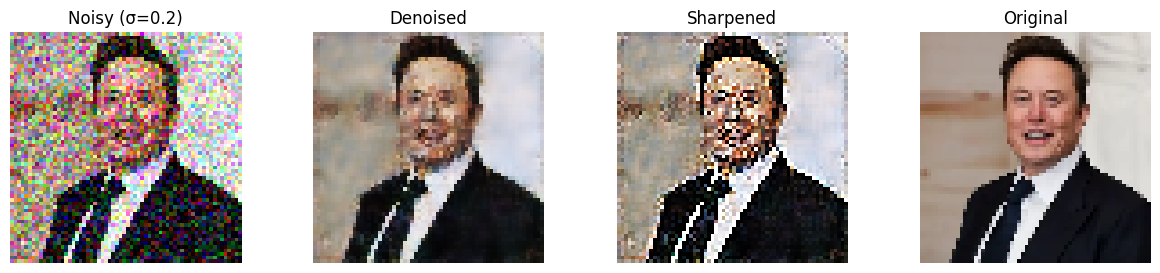

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Processing Screenshot 2025-02-26 223609 (3).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sigma=0.05:
  Denoised PSNR: 26.91 dB, SSIM: 0.91
  Sharpened PSNR: 19.39 dB, SSIM: 0.75


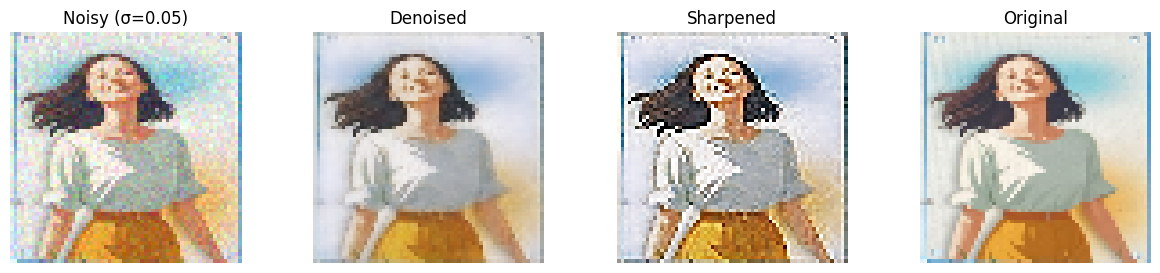

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sigma=0.1:
  Denoised PSNR: 25.07 dB, SSIM: 0.85
  Sharpened PSNR: 18.42 dB, SSIM: 0.68


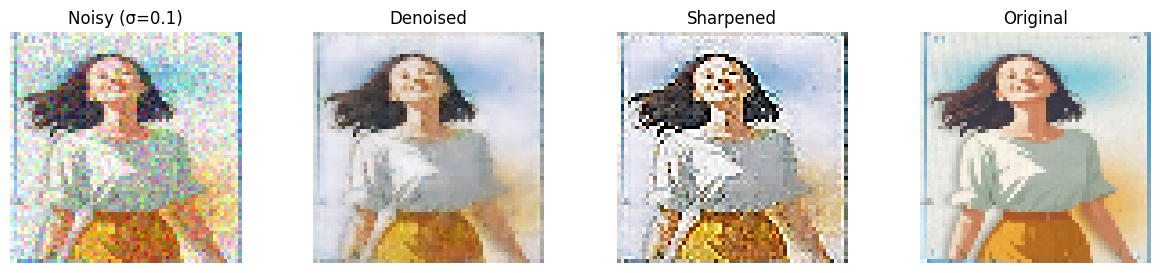

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sigma=0.2:
  Denoised PSNR: 22.29 dB, SSIM: 0.74
  Sharpened PSNR: 17.33 dB, SSIM: 0.59


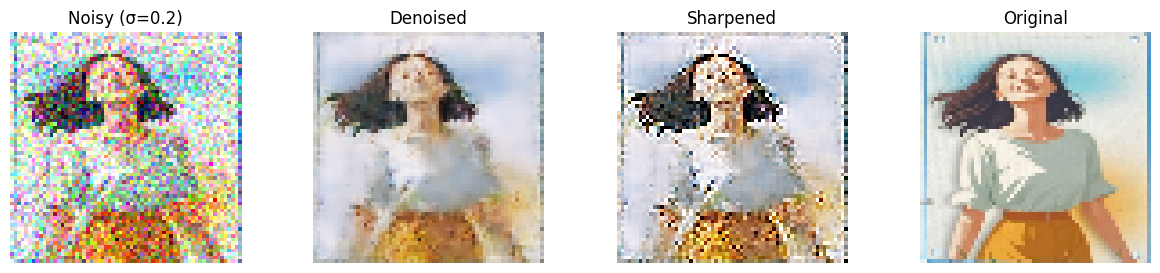

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import tensorflow as tf
import cv2
import numpy as np
import os
from google.colab import files
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import io

# Define loss
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Step 1: Upload the .h5 file
print("Upload your model file (model_bsds500_mixed.h5):")
uploaded_model = files.upload()
model_filename = list(uploaded_model.keys())[0]
model_path = f"/content/{model_filename}"

# Step 2: Load the model
model = load_model(model_path, custom_objects={'combined_loss': combined_loss})

# Step 3: Download and preprocess DIV2K
!wget -O /content/DIV2K_train_HR.zip "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!unzip -q /content/DIV2K_train_HR.zip -d /content/DIV2K

def load_div2k_images(directory, size=(64, 64)):
    images = []
    for file in os.listdir(directory):
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(directory, file))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size) / 255.0
            images.append(img)
    return np.array(images)

def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

div2k_dir = "/content/DIV2K/DIV2K_train_HR/"
x_train = load_div2k_images(div2k_dir)
print(f"Loaded {len(x_train)} DIV2K images")

# Create noisy versions with different sigma values
sigmas = [0.05, 0.1, 0.2]
x_train_noisy_mixed = []
x_train_mixed = []
for i, img in enumerate(x_train):
    sigma = sigmas[i % len(sigmas)]
    noisy_img = add_noise(np.expand_dims(img, 0), sigma=sigma)[0]
    x_train_noisy_mixed.append(noisy_img)
    x_train_mixed.append(img)
x_train_noisy_mixed = np.array(x_train_noisy_mixed)
x_train_mixed = np.array(x_train_mixed)

# Upload your screenshot
print("Upload your screenshot (e.g., Screenshot 2025-02-26 223609.png):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img, (64, 64)) / 255.0

# Add screenshot with mixed noise
for sigma in sigmas:
    real_img_train = np.expand_dims(real_img, 0)
    real_img_noisy_train = add_noise(real_img_train, sigma=sigma)
    x_train_mixed = np.concatenate([x_train_mixed, real_img_train])
    x_train_noisy_mixed = np.concatenate([x_train_noisy_mixed, real_img_noisy_train])
print(f"Total training images: {len(x_train_mixed)}")

# Step 4: Fine-tune the model
model.compile(optimizer='adam', loss=combined_loss)  # Recompile if needed
model.fit(x_train_noisy_mixed, x_train_mixed, epochs=20, batch_size=16,
          validation_split=0.1,
          callbacks=[ModelCheckpoint('/content/drive/MyDrive/CW2_Image_Denoising/models/model_finetuned_div2k.h5', save_best_only=True)])

# Step 5: Test with multiple images
model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_finetuned_div2k.h5',
                   custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.05, 0.1, 0.2]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = model.predict(real_img_noisy)[0]

        # Milder sharpening
        sharpen_kernel = np.array([[0, -0.5, 0], [-0.5, 3, -0.5], [0, -0.5, 0]])
        real_denoised_sharp = cv2.filter2D(real_denoised, -1, sharpen_kernel)
        real_denoised_sharp = np.clip(real_denoised_sharp, 0, 1)

        # Metrics
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        psnr_sharp = peak_signal_noise_ratio(real_img, real_denoised_sharp, data_range=1.0)
        ssim_sharp = structural_similarity(real_img, real_denoised_sharp, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")
        print(f"  Sharpened PSNR: {psnr_sharp:.2f} dB, SSIM: {ssim_sharp:.2f}")

        # Visualize
        plt.figure(figsize=(15, 3))
        plt.subplot(1, 4, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(real_denoised_sharp); plt.title("Sharpened"); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_div2k.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

# Step 6: Download the fine-tuned model
print("Downloading the fine-tuned model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_finetuned_div2k.h5')

In [7]:
import tensorflow as tf
import cv2
import numpy as np
import os
from google.colab import files
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import io

# Define loss
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Step 1: Upload the .h5 file
print("Upload your model file (model_bsds500_mixed.h5):")
uploaded_model = files.upload()
model_filename = list(uploaded_model.keys())[0]
model_path = f"/content/{model_filename}"

# Step 2: Load the model
model = load_model(model_path, custom_objects={'combined_loss': combined_loss})

# Step 3: Download and preprocess datasets
# BSDS500
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
!tar -xzvf BSR_full.tgz
bsds500_train_dir = "/content/BSR/BSDS500/data/images/train/"
bsds500_val_dir = "/content/BSR/BSDS500/data/images/val/"
bsds500_test_dir = "/content/BSR/BSDS500/data/images/test/"

train_files = [os.path.join(bsds500_train_dir, f) for f in os.listdir(bsds500_train_dir) if f.endswith('.jpg')]
val_files = [os.path.join(bsds500_val_dir, f) for f in os.listdir(bsds500_val_dir) if f.endswith('.jpg')]
test_files = [os.path.join(bsds500_test_dir, f) for f in os.listdir(bsds500_test_dir) if f.endswith('.jpg')]
bsds500_files = train_files + val_files

# DIV2K
!wget -O /content/DIV2K_train_HR.zip "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!unzip -q /content/DIV2K_train_HR.zip -d /content/DIV2K
div2k_dir = "/content/DIV2K/DIV2K_train_HR/"
div2k_files = [os.path.join(div2k_dir, f) for f in os.listdir(div2k_dir) if f.endswith('.png')]

# SIDD (subset)
!wget -O /content/SIDD_Small.zip "https://www.eecs.yorku.ca/~kamel/sidd/dataset/SIDD_Small_sRGB_Only.zip"
!unzip -q /content/SIDD_Small.zip -d /content/SIDD
sidd_dir = "/content/SIDD/Data/"
sidd_files = []
for subdir in os.listdir(sidd_dir):
    subdir_path = os.path.join(sidd_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('GT_SRGB.PNG'):  # Ground truth images
                sidd_files.append(os.path.join(subdir_path, file))
sidd_files = sidd_files[:200]  # Use 200 images

# Load images
def load_images(file_list, size=(64, 64)):
    images = []
    for file in file_list:
        img = cv2.imread(file)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) / 255.0
        images.append(img)
    return np.array(images)

def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

# Load all datasets
x_train_bsds500 = load_images(bsds500_files)
x_train_div2k = load_images(div2k_files)
x_train_sidd = load_images(sidd_files)
x_train = np.concatenate([x_train_bsds500, x_train_div2k, x_train_sidd])
print(f"Loaded {len(x_train)} images (BSDS500: {len(x_train_bsds500)}, DIV2K: {len(x_train_div2k)}, SIDD: {len(x_train_sidd)})")

# Create noisy versions with a wider range of sigma
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3]
x_train_noisy_mixed = []
x_train_mixed = []
for i, img in enumerate(x_train):
    sigma = sigmas[i % len(sigmas)]
    noisy_img = add_noise(np.expand_dims(img, 0), sigma=sigma)[0]
    x_train_noisy_mixed.append(noisy_img)
    x_train_mixed.append(img)
x_train_noisy_mixed = np.array(x_train_noisy_mixed)
x_train_mixed = np.array(x_train_mixed)

# Upload your screenshot
print("Upload your screenshot (e.g., Screenshot 2025-02-26 223609.png):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img, (64, 64)) / 255.0

# Add screenshot with mixed noise
for sigma in sigmas:
    real_img_train = np.expand_dims(real_img, 0)
    real_img_noisy_train = add_noise(real_img_train, sigma=sigma)
    x_train_mixed = np.concatenate([x_train_mixed, real_img_train])
    x_train_noisy_mixed = np.concatenate([x_train_noisy_mixed, real_img_noisy_train])
print(f"Total training images: {len(x_train_mixed)}")

# Step 4: Fine-tune with enhanced U-Net
def enhanced_unet_autoencoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)
    b = layers.Dropout(0.1)(b)
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.1)(c3)
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.1)(c4)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)
    return Model(inputs, outputs)

# Transfer weights to the enhanced model
new_model = enhanced_unet_autoencoder()
for layer in new_model.layers:
    try:
        layer.set_weights(model.get_layer(layer.name).get_weights())
    except:
        print(f"Skipping weights for layer {layer.name} due to shape mismatch")

# Compile new model
new_model.compile(optimizer='adam', loss=combined_loss)

# Fine-tune
new_model.fit(x_train_noisy_mixed, x_train_mixed, epochs=100, batch_size=16,
              validation_split=0.1,
              callbacks=[ModelCheckpoint('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5', save_best_only=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

# Step 5: Test with multiple images
new_model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5',
                       custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = new_model.predict(real_img_noisy)[0]

        # Skip sharpening
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")

        # Visualize
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_enhanced.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

# Step 6: Download the enhanced model
print("Downloading the enhanced model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5')

Upload your model file (model_bsds500_mixed.h5):


Saving model_bsds500_mixed.h5 to model_bsds500_mixed (1).h5
--2025-03-25 18:04:57--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170185251 (162M) [application/x-tar]
Saving to: ‘BSR_full.tgz.1’

BSR_full.tgz.1      100%[===================>] 162.30M  42.9MB/s    in 4.3s    

2025-03-25 18:05:01 (37.7 MB/s) - ‘BSR_full.tgz.1’ saved [170185251/170185251]

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source

FileNotFoundError: [Errno 2] No such file or directory: '/content/SIDD/Data/'

In [8]:
import tensorflow as tf
import cv2
import numpy as np
import os
from google.colab import files
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import io

# Define loss
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Step 1: Upload the .h5 file
print("Upload your model file (model_bsds500_mixed.h5):")
uploaded_model = files.upload()
model_filename = list(uploaded_model.keys())[0]
model_path = f"/content/{model_filename}"

# Step 2: Load the model
model = load_model(model_path, custom_objects={'combined_loss': combined_loss})

# Step 3: Download and preprocess datasets
# BSDS500
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
!tar -xzvf BSR_full.tgz
bsds500_train_dir = "/content/BSR/BSDS500/data/images/train/"
bsds500_val_dir = "/content/BSR/BSDS500/data/images/val/"
bsds500_test_dir = "/content/BSR/BSDS500/data/images/test/"

train_files = [os.path.join(bsds500_train_dir, f) for f in os.listdir(bsds500_train_dir) if f.endswith('.jpg')]
val_files = [os.path.join(bsds500_val_dir, f) for f in os.listdir(bsds500_val_dir) if f.endswith('.jpg')]
test_files = [os.path.join(bsds500_test_dir, f) for f in os.listdir(bsds500_test_dir) if f.endswith('.jpg')]
bsds500_files = train_files + val_files

# DIV2K
!wget -O /content/DIV2K_train_HR.zip "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!unzip -q -o /content/DIV2K_train_HR.zip -d /content/DIV2K
div2k_dir = "/content/DIV2K/DIV2K_train_HR/"
div2k_files = [os.path.join(div2k_dir, f) for f in os.listdir(div2k_dir) if f.endswith('.png')]

# SIDD (subset)
!wget -O /content/SIDD_Small.zip "https://www.eecs.yorku.ca/~kamel/sidd/dataset/SIDD_Small_sRGB_Only.zip"
!unzip -q -o /content/SIDD_Small.zip -d /content/SIDD
sidd_dir = "/content/SIDD/Data/"
sidd_files = []
for subdir in os.listdir(sidd_dir):
    subdir_path = os.path.join(sidd_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('GT_SRGB.PNG'):  # Ground truth images
                sidd_files.append(os.path.join(subdir_path, file))
sidd_files = sidd_files[:200]  # Use 200 images

# Load images
def load_images(file_list, size=(64, 64)):
    images = []
    for file in file_list:
        img = cv2.imread(file)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) / 255.0
        images.append(img)
    return np.array(images)

def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

# Load all datasets
x_train_bsds500 = load_images(bsds500_files)
x_train_div2k = load_images(div2k_files)
x_train_sidd = load_images(sidd_files)
x_train = np.concatenate([x_train_bsds500, x_train_div2k, x_train_sidd])
print(f"Loaded {len(x_train)} images (BSDS500: {len(x_train_bsds500)}, DIV2K: {len(x_train_div2k)}, SIDD: {len(x_train_sidd)})")

# Create noisy versions with a wider range of sigma
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3]
x_train_noisy_mixed = []
x_train_mixed = []
for i, img in enumerate(x_train):
    sigma = sigmas[i % len(sigmas)]
    noisy_img = add_noise(np.expand_dims(img, 0), sigma=sigma)[0]
    x_train_noisy_mixed.append(noisy_img)
    x_train_mixed.append(img)
x_train_noisy_mixed = np.array(x_train_noisy_mixed)
x_train_mixed = np.array(x_train_mixed)

# Upload your screenshot
print("Upload your screenshot (e.g., Screenshot 2025-02-26 223609.png):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img, (64, 64)) / 255.0

# Add screenshot with mixed noise
for sigma in sigmas:
    real_img_train = np.expand_dims(real_img, 0)
    real_img_noisy_train = add_noise(real_img_train, sigma=sigma)
    x_train_mixed = np.concatenate([x_train_mixed, real_img_train])
    x_train_noisy_mixed = np.concatenate([x_train_noisy_mixed, real_img_noisy_train])
print(f"Total training images: {len(x_train_mixed)}")

# Step 4: Fine-tune with enhanced U-Net
def enhanced_unet_autoencoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)
    b = layers.Dropout(0.1)(b)
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.1)(c3)
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.1)(c4)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)
    return Model(inputs, outputs)

# Transfer weights to the enhanced model
new_model = enhanced_unet_autoencoder()
for layer in new_model.layers:
    try:
        layer.set_weights(model.get_layer(layer.name).get_weights())
    except:
        print(f"Skipping weights for layer {layer.name} due to shape mismatch")

# Compile new model
new_model.compile(optimizer='adam', loss=combined_loss)

# Fine-tune
new_model.fit(x_train_noisy_mixed, x_train_mixed, epochs=100, batch_size=8,  # Reduced batch size
              validation_split=0.1,
              callbacks=[ModelCheckpoint('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5', save_best_only=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

# Step 5: Test with multiple images
new_model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5',
                       custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = new_model.predict(real_img_noisy)[0]

        # Skip sharpening
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")

        # Visualize
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_enhanced.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

# Step 6: Download the enhanced model
print("Downloading the enhanced model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5')

Upload your model file (model_bsds500_mixed.h5):


Saving model_bsds500_mixed.h5 to model_bsds500_mixed (2).h5
--2025-03-25 18:12:14--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170185251 (162M) [application/x-tar]
Saving to: ‘BSR_full.tgz.2’

BSR_full.tgz.2      100%[===================>] 162.30M  40.2MB/s    in 4.7s    

2025-03-25 18:12:19 (34.8 MB/s) - ‘BSR_full.tgz.2’ saved [170185251/170185251]

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source

FileNotFoundError: [Errno 2] No such file or directory: '/content/SIDD/Data/'

Upload your model file (model_bsds500_mixed.h5):


Saving model_bsds500_mixed.h5 to model_bsds500_mixed (3).h5
--2025-03-25 18:19:06--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170185251 (162M) [application/x-tar]
Saving to: ‘BSR_full.tgz.3’

BSR_full.tgz.3      100%[===================>] 162.30M  31.7MB/s    in 5.8s    

2025-03-25 18:19:12 (27.9 MB/s) - ‘BSR_full.tgz.3’ saved [170185251/170185251]

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source

Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609 (4).png
Total training images: 1105
Skipping weights for layer input_layer_1 due to shape mismatch
Skipping weights for layer conv2d_6 due to shape mismatch
Skipping weights for layer conv2d_7 due to shape mismatch
Skipping weights for layer dropout_5 due to shape mismatch
Skipping weights for layer max_pooling2d_2 due to shape mismatch
Skipping weights for layer conv2d_8 due to shape mismatch
Skipping weights for layer conv2d_9 due to shape mismatch
Skipping weights for layer dropout_6 due to shape mismatch
Skipping weights for layer max_pooling2d_3 due to shape mismatch
Skipping weights for layer conv2d_10 due to shape mismatch
Skipping weights for layer conv2d_11 due to shape mismatch
Skipping weights for layer dropout_7 due to shape mismatch
Skipping weights for layer up_sampling2d_2 due to shape mismatch
Skipping weights for layer concatenate_2 due to shape mismatch
Skipping weights for layer conv2d_12 due to 

125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - loss: 0.1747 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 2/100
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0812

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0811 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 3/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0792

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0792 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0709 - val_loss: 0.0680 - learning_rate: 0.0010
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0723

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0722 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 6/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0664

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0664 - val_loss: 0.0629 - learning_rate: 0.0010
Epoch 7/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0638

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0638 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 8/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0675

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0674 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0636 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0611 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 11/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0635

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0634 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 12/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0593

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0593 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0598 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0605 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 15/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0597

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0597 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 16/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0582 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 17/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0601

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0601 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 18/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0558 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 19/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0573

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0573 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 20/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0542 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 21/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0554 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 22/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0571 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 23/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0559 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 24/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0547 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 25/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0561

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0560 - val_loss: 0.0510 - learning_rate: 5.0000e-04
Epoch 26/100
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0518

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0518 - val_loss: 0.0507 - learning_rate: 5.0000e-04
Epoch 27/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0515 - val_loss: 0.0508 - learning_rate: 5.0000e-04
Epoch 28/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0543

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0543 - val_loss: 0.0506 - learning_rate: 5.0000e-04
Epoch 29/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0516

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0516 - val_loss: 0.0502 - learning_rate: 5.0000e-04
Epoch 30/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0524 - val_loss: 0.0505 - learning_rate: 5.0000e-04
Epoch 31/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0538 - val_loss: 0.0506 - learning_rate: 5.0000e-04
Epoch 32/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0508

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0508 - val_loss: 0.0494 - learning_rate: 5.0000e-04
Epoch 33/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0521 - val_loss: 0.0507 - learning_rate: 5.0000e-04
Epoch 34/100
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0509

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0509 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 35/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0498 - val_loss: 0.0499 - learning_rate: 5.0000e-04
Epoch 36/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0511 - val_loss: 0.0511 - learning_rate: 5.0000e-04
Epoch 37/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0532 - val_loss: 0.0498 - learning_rate: 5.0000e-04
Epoch 38/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0503

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0502 - val_loss: 0.0491 - learning_rate: 2.5000e-04
Epoch 39/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0494

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0494 - val_loss: 0.0491 - learning_rate: 2.5000e-04
Epoch 40/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0495

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0495 - val_loss: 0.0491 - learning_rate: 2.5000e-04
Epoch 41/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0481 - val_loss: 0.0492 - learning_rate: 2.5000e-04
Epoch 42/100
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0482

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0482 - val_loss: 0.0488 - learning_rate: 2.5000e-04
Epoch 43/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0466 - val_loss: 0.0488 - learning_rate: 2.5000e-04
Epoch 44/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0484 - val_loss: 0.0490 - learning_rate: 2.5000e-04
Epoch 45/100
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0448

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0448 - val_loss: 0.0488 - learning_rate: 2.5000e-04
Epoch 46/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0476 - val_loss: 0.0492 - learning_rate: 2.5000e-04
Epoch 47/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0474 - val_loss: 0.0492 - learning_rate: 2.5000e-04
Epoch 48/100
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0469

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0469 - val_loss: 0.0486 - learning_rate: 1.2500e-04
Epoch 49/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0445 - val_loss: 0.0486 - learning_rate: 1.2500e-04
Epoch 50/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0456 - val_loss: 0.0487 - learning_rate: 1.2500e-04
Epoch 51/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0446 - val_loss: 0.0489 - learning_rate: 1.2500e-04
Epoch 52/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0455 - val_loss: 0.0488 - learning_rate: 1.2500e-04
Epoch 53/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0454 - val_loss: 0.0488 - learning_rate: 1.2500e-04
Epoch 54/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0455 - val_loss: 0.0488 - learning_rate: 6.2500e-05
Epoch 55/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0452 - val_loss: 0.0489 - learning_rate: 6.2500e-05
Epoch 56/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0476 - val_l

Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving Screenshot 2025-02-26 223609.png to Screenshot 2025-02-26 223609 (5).png

Processing Screenshot 2025-02-26 223609 (5).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sigma=0.01:
  Denoised PSNR: 30.29 dB, SSIM: 0.97


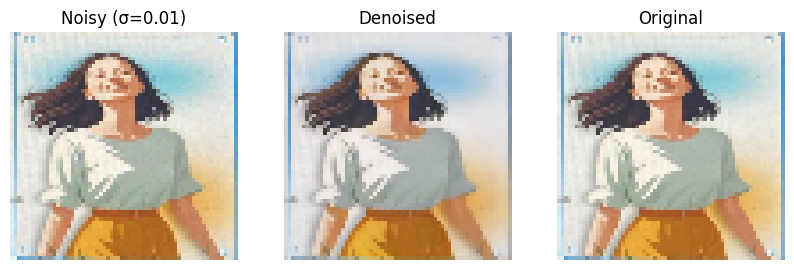

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sigma=0.05:
  Denoised PSNR: 28.47 dB, SSIM: 0.93


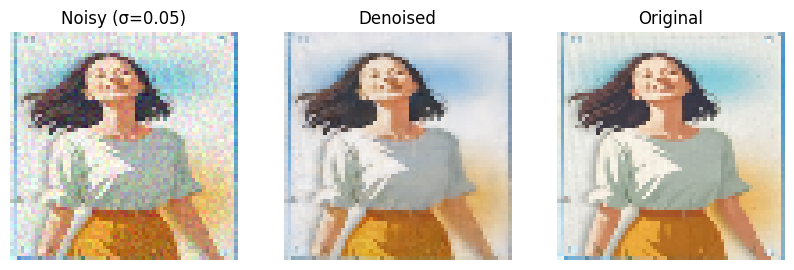

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.1:
  Denoised PSNR: 26.04 dB, SSIM: 0.87


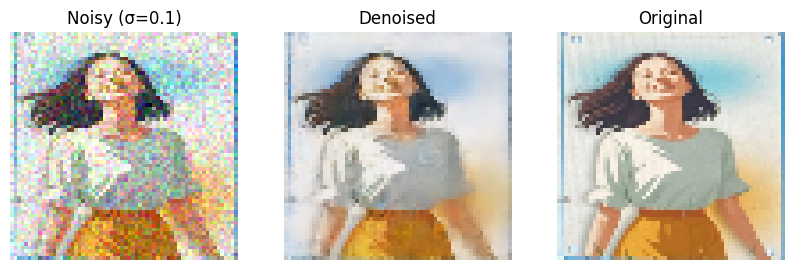

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.2:
  Denoised PSNR: 22.78 dB, SSIM: 0.76


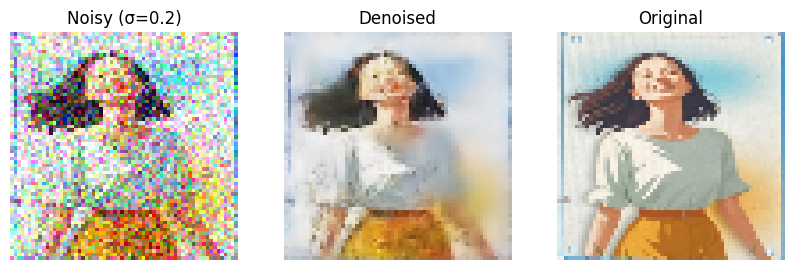

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sigma=0.3:
  Denoised PSNR: 20.94 dB, SSIM: 0.67


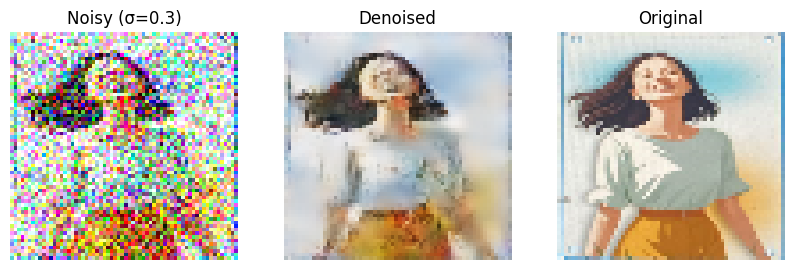

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
import tensorflow as tf
import cv2
import numpy as np
import os
from google.colab import files
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import io
from tensorflow.keras.models import load_model

# Define loss
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

# Step 1: Upload the .h5 file
print("Upload your model file (model_bsds500_mixed.h5):")
uploaded_model = files.upload()
model_filename = list(uploaded_model.keys())[0]
model_path = f"/content/{model_filename}"

# Step 2: Load the model
model = load_model(model_path, custom_objects={'combined_loss': combined_loss})

# Step 3: Download and preprocess datasets
# BSDS500
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz
!tar -xzvf BSR_full.tgz
bsds500_train_dir = "/content/BSR/BSDS500/data/images/train/"
bsds500_val_dir = "/content/BSR/BSDS500/data/images/val/"
bsds500_test_dir = "/content/BSR/BSDS500/data/images/test/"

train_files = [os.path.join(bsds500_train_dir, f) for f in os.listdir(bsds500_train_dir) if f.endswith('.jpg')]
val_files = [os.path.join(bsds500_val_dir, f) for f in os.listdir(bsds500_val_dir) if f.endswith('.jpg')]
test_files = [os.path.join(bsds500_test_dir, f) for f in os.listdir(bsds500_test_dir) if f.endswith('.jpg')]
bsds500_files = train_files + val_files

# DIV2K
!wget -O /content/DIV2K_train_HR.zip "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!unzip -q -o /content/DIV2K_train_HR.zip -d /content/DIV2K
div2k_dir = "/content/DIV2K/DIV2K_train_HR/"
div2k_files = [os.path.join(div2k_dir, f) for f in os.listdir(div2k_dir) if f.endswith('.png')]

# Load images
def load_images(file_list, size=(64, 64)):
    images = []
    for file in file_list:
        img = cv2.imread(file)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) / 255.0
        images.append(img)
    return np.array(images)

def add_noise(images, sigma=0.05):
    noise = np.random.normal(0, sigma, images.shape)
    return np.clip(images + noise, 0, 1)

# Load datasets (BSDS500 and DIV2K only)
x_train_bsds500 = load_images(bsds500_files)
x_train_div2k = load_images(div2k_files)
x_train = np.concatenate([x_train_bsds500, x_train_div2k])
print(f"Loaded {len(x_train)} images (BSDS500: {len(x_train_bsds500)}, DIV2K: {len(x_train_div2k)})")

# Create noisy versions with a wider range of sigma
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3]
x_train_noisy_mixed = []
x_train_mixed = []
for i, img in enumerate(x_train):
    sigma = sigmas[i % len(sigmas)]
    noisy_img = add_noise(np.expand_dims(img, 0), sigma=sigma)[0]
    x_train_noisy_mixed.append(noisy_img)
    x_train_mixed.append(img)
x_train_noisy_mixed = np.array(x_train_noisy_mixed)
x_train_mixed = np.array(x_train_mixed)

# Upload your screenshot
print("Upload your screenshot (e.g., Screenshot 2025-02-26 223609.png):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
real_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img, (64, 64)) / 255.0

# Add screenshot with mixed noise
for sigma in sigmas:
    real_img_train = np.expand_dims(real_img, 0)
    real_img_noisy_train = add_noise(real_img_train, sigma=sigma)
    x_train_mixed = np.concatenate([x_train_mixed, real_img_train])
    x_train_noisy_mixed = np.concatenate([x_train_noisy_mixed, real_img_noisy_train])
print(f"Total training images: {len(x_train_mixed)}")

# Step 4: Fine-tune with enhanced U-Net
def enhanced_unet_autoencoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)
    b = layers.Dropout(0.1)(b)
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.1)(c3)
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.1)(c4)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)
    return Model(inputs, outputs)

# Transfer weights to the enhanced model
new_model = enhanced_unet_autoencoder()
for layer in new_model.layers:
    try:
        layer.set_weights(model.get_layer(layer.name).get_weights())
    except:
        print(f"Skipping weights for layer {layer.name} due to shape mismatch")

# Compile new model
new_model.compile(optimizer='adam', loss=combined_loss)

# Fine-tune
new_model.fit(x_train_noisy_mixed, x_train_mixed, epochs=100, batch_size=8,
              validation_split=0.1,
              callbacks=[ModelCheckpoint('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5', save_best_only=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])

# Step 5: Test with multiple images
new_model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5',
                       custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = new_model.predict(real_img_noisy)[0]

        # Skip sharpening
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")

        # Visualize
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_enhanced.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

# Step 6: Download the enhanced model
print("Downloading the enhanced model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5')


Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving download (5).jpeg to download (5) (2).jpeg
Saving download.webp to download (2).webp

Processing download (5) (2).jpeg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Sigma=0.01:
  Denoised PSNR: 29.91 dB, SSIM: 0.95


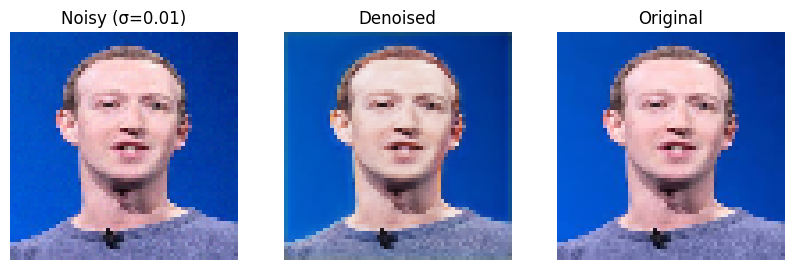

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sigma=0.05:
  Denoised PSNR: 28.24 dB, SSIM: 0.92


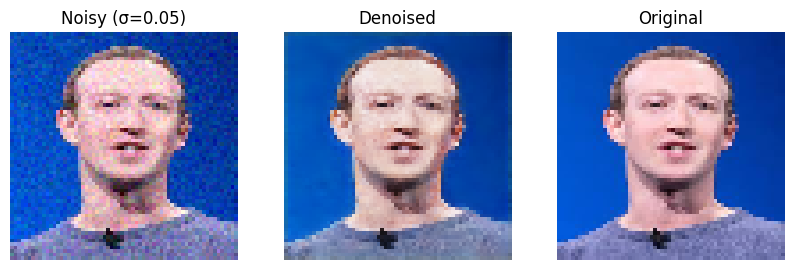

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sigma=0.1:
  Denoised PSNR: 25.65 dB, SSIM: 0.87


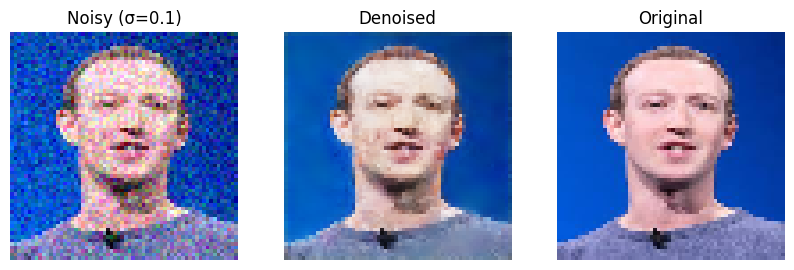

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sigma=0.2:
  Denoised PSNR: 22.21 dB, SSIM: 0.77


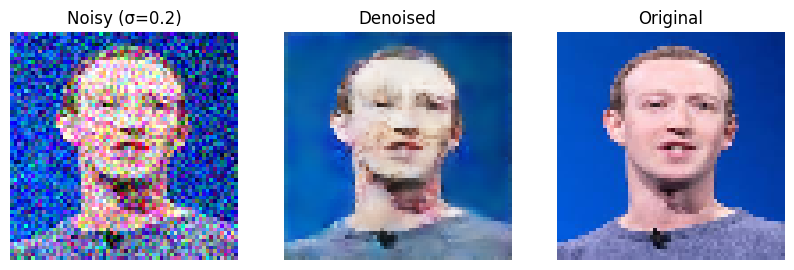

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sigma=0.3:
  Denoised PSNR: 20.45 dB, SSIM: 0.68


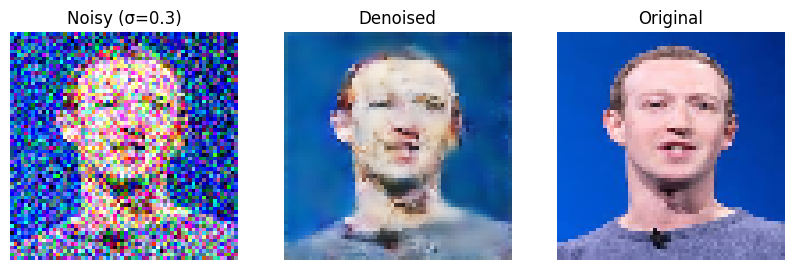

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Processing download (2).webp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sigma=0.01:
  Denoised PSNR: 36.16 dB, SSIM: 0.98


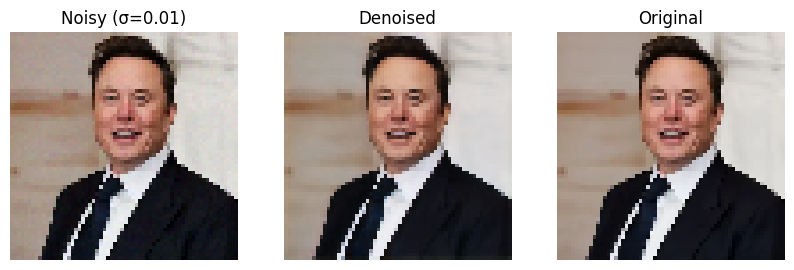

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sigma=0.05:
  Denoised PSNR: 32.35 dB, SSIM: 0.94


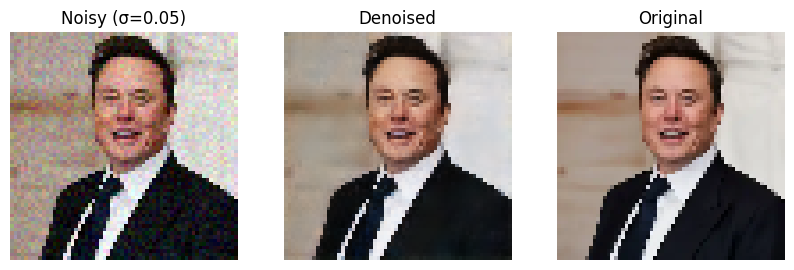

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sigma=0.1:
  Denoised PSNR: 29.20 dB, SSIM: 0.90


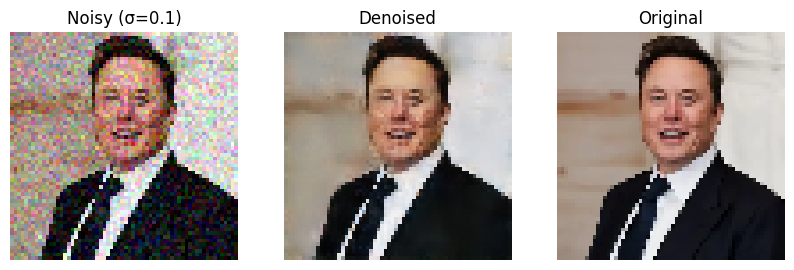

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sigma=0.2:
  Denoised PSNR: 25.37 dB, SSIM: 0.81


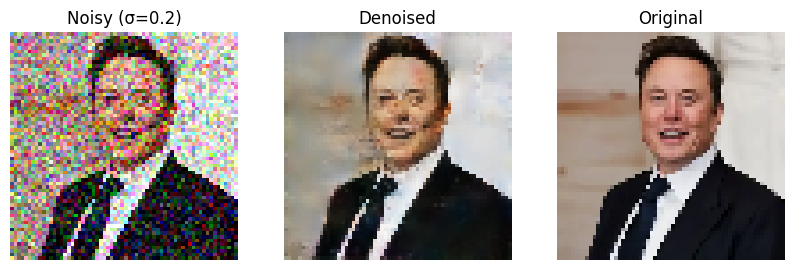

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sigma=0.3:
  Denoised PSNR: 22.86 dB, SSIM: 0.73


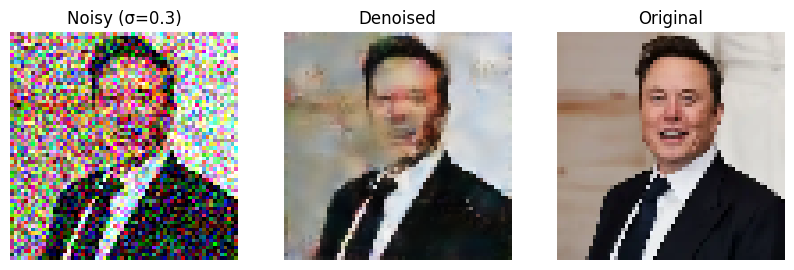

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Step 5: Test with multiple images
new_model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5',
                       custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = new_model.predict(real_img_noisy)[0]

        # Skip sharpening
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")

        # Visualize
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_enhanced.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)

# Step 6: Download the enhanced model
print("Downloading the enhanced model to your device...")
files.download('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5')

Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.


Saving download (4).png to download (4).png
Saving istockphoto-1416797815-612x612.jpg to istockphoto-1416797815-612x612.jpg

Processing download (4).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Sigma=0.01:
  Denoised PSNR: 28.42 dB, SSIM: 0.99


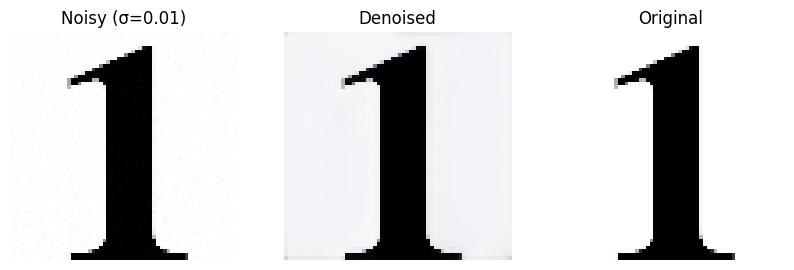

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sigma=0.05:
  Denoised PSNR: 27.91 dB, SSIM: 0.95


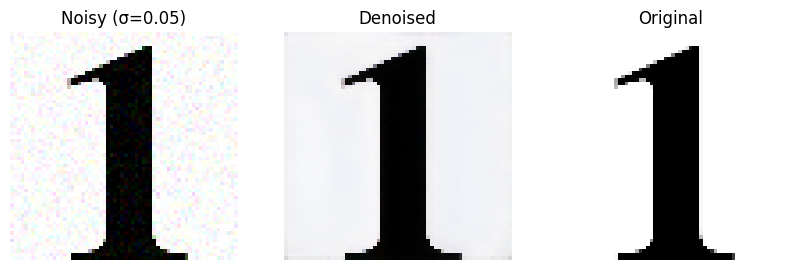

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sigma=0.1:
  Denoised PSNR: 27.19 dB, SSIM: 0.90


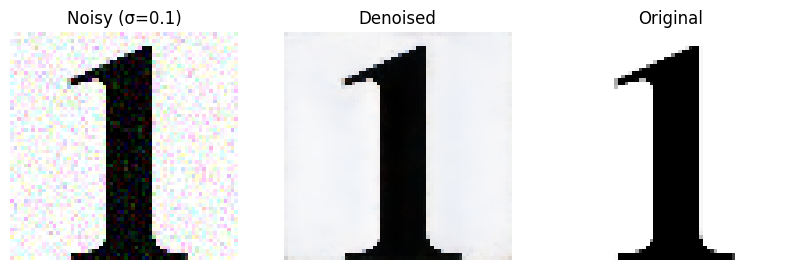

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sigma=0.2:
  Denoised PSNR: 25.74 dB, SSIM: 0.89


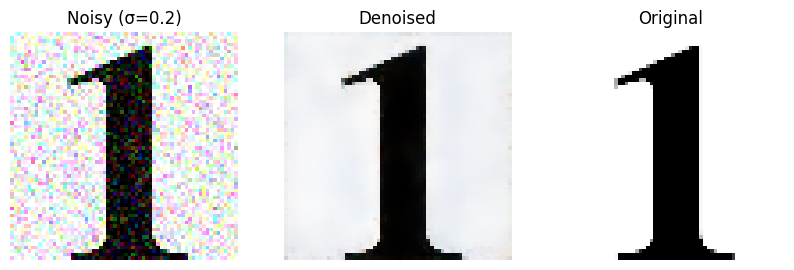

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sigma=0.3:
  Denoised PSNR: 23.61 dB, SSIM: 0.85


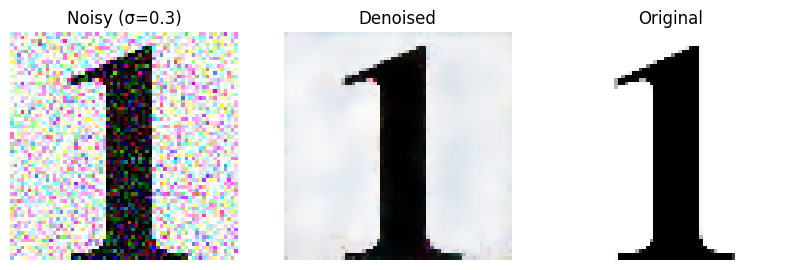

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Processing istockphoto-1416797815-612x612.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sigma=0.01:
  Denoised PSNR: 39.42 dB, SSIM: 0.98


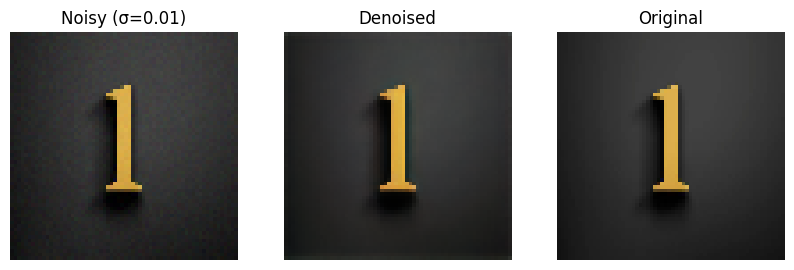

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sigma=0.05:
  Denoised PSNR: 36.31 dB, SSIM: 0.95


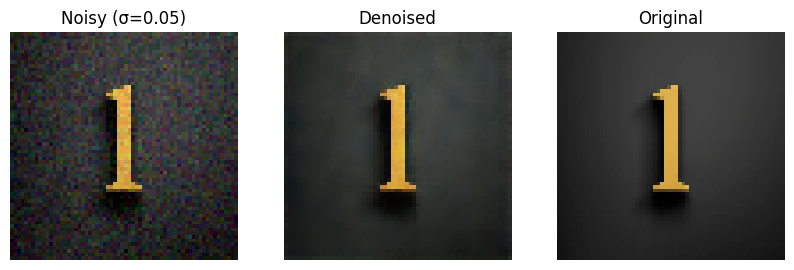

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sigma=0.1:
  Denoised PSNR: 33.65 dB, SSIM: 0.93


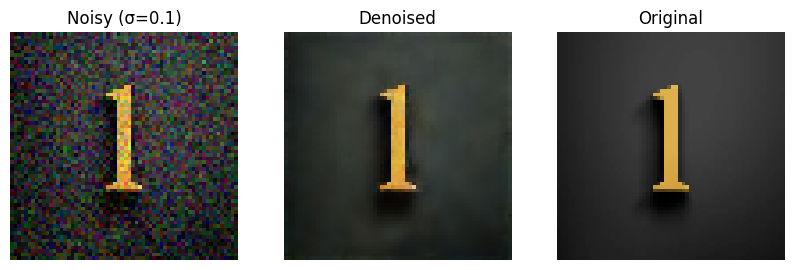

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.2:
  Denoised PSNR: 29.97 dB, SSIM: 0.84


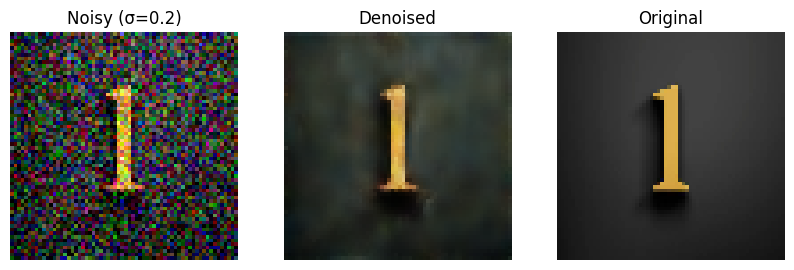

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sigma=0.3:
  Denoised PSNR: 27.32 dB, SSIM: 0.72


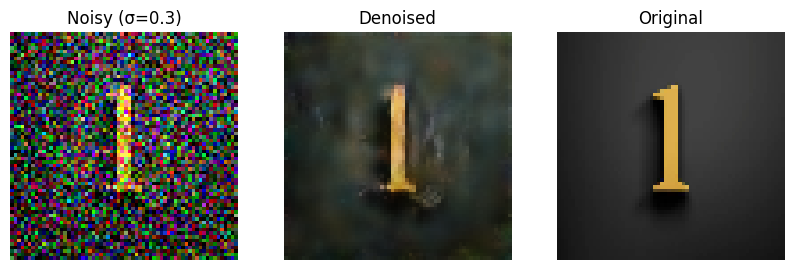

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Step 5: Test with multiple images
new_model = load_model('/content/drive/MyDrive/CW2_Image_Denoising/models/model_enhanced.h5',
                       custom_objects={'combined_loss': combined_loss})

print("Upload multiple images to test (e.g., .jpg, .png). Click 'Cancel Upload' when done.")
uploaded_test = files.upload()

for filename in uploaded_test.keys():
    print(f"\nProcessing {filename}...")
    real_img = cv2.imdecode(np.frombuffer(uploaded_test[filename], np.uint8), cv2.IMREAD_COLOR)
    if real_img is None:
        print(f"Failed to load {filename}. Skipping.")
        continue
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    real_img = cv2.resize(real_img, (64, 64)) / 255.0

    for sigma in [0.01, 0.05, 0.1, 0.2, 0.3]:
        real_img_noisy = add_noise(np.expand_dims(real_img, 0), sigma=sigma)
        real_denoised = new_model.predict(real_img_noisy)[0]

        # Skip sharpening
        psnr_denoised = peak_signal_noise_ratio(real_img, real_denoised, data_range=1.0)
        ssim_denoised = structural_similarity(real_img, real_denoised, channel_axis=-1, data_range=1.0)
        print(f"Sigma={sigma}:")
        print(f"  Denoised PSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.2f}")

        # Visualize
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1); plt.imshow(real_img_noisy[0]); plt.title(f"Noisy (σ={sigma})"); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(real_denoised); plt.title("Denoised"); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(real_img); plt.title("Original"); plt.axis('off')
        output_filename = f'/content/test_{filename.split(".")[0]}_sigma_{sigma}_enhanced.png'
        plt.savefig(output_filename)
        plt.show()
        files.download(output_filename)
